In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer
import pandas as pd
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

# Define stop words for text cleaning
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Load the dataset
df = pd.read_csv("cyberbullying_tweets.csv")

In [11]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [12]:
df['tweet_clean'] = [clean_tweet(tweet) for tweet in df['tweet_text']]

In [13]:
df.drop_duplicates('tweet_clean', inplace=True)

In [14]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7910
age                    7817
ethnicity              7425
gender                 7286
not_cyberbullying      6095
other_cyberbullying    4922
Name: count, dtype: int64

In [15]:
# Data preprocessing
labEncoder = LabelEncoder()
labelsEncoded = labEncoder.fit_transform(df["cyberbullying_type"])

In [16]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['tweet_clean'], labelsEncoded, test_size=0.2, random_state=42)

# Reset indices
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)

In [17]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
class TextClassificationDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

In [19]:
# Create datasets and dataloaders
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer=tokenizer, max_length=128)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer=tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [20]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, n_layers=2, bidirectional=True, dropout=0.5):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        packed_output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return output

In [25]:
# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get vocabulary size from tokenizer
vocab_size = tokenizer.vocab_size

model = RNNClassifier(vocab_size=vocab_size, embedding_dim=128, hidden_dim=256, num_classes=len(labEncoder.classes_)).to(device)

optimizer = AdamW(model.parameters(), lr=1e-3)

In [26]:
def train(model, data_loader, optimizer, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        labels = labels.long()
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

In [27]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual.extend(labels.cpu().tolist())
    return accuracy_score(y_true=actual, y_pred=predictions), classification_report(y_true=actual, y_pred=predictions), actual, predictions

In [28]:
# Train model
for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    train(model, train_dataloader, optimizer, device)
    accuracy, report, actual, predictions = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/5
Validation Accuracy: 0.8205
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1534
           1       0.96      0.97      0.97      1494
           2       0.93      0.80      0.86      1443
           3       0.60      0.38      0.46      1257
           4       0.47      0.73      0.57       980
           5       0.93      0.95      0.94      1583

    accuracy                           0.82      8291
   macro avg       0.81      0.80      0.79      8291
weighted avg       0.83      0.82      0.82      8291

Epoch 2/5
Validation Accuracy: 0.8416
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1534
           1       0.97      0.98      0.98      1494
           2       0.91      0.83      0.87      1443
           3       0.55      0.67      0.61      1257
           4       0.56      0.49      0.52       980
           5       0.95      0.95      0.95      1583

 

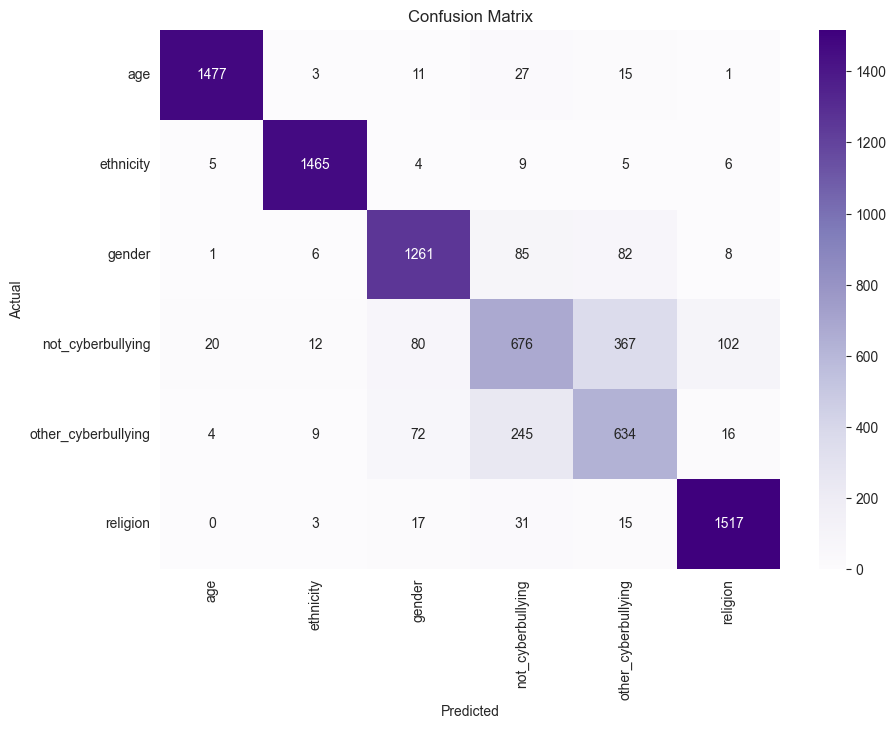

In [29]:
# Compute confusion matrix
cm = confusion_matrix(actual, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labEncoder.classes_, yticklabels=labEncoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
def predict_class(text, model, tokenizer, device, classes, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return classes[preds.item()]

In [31]:
# Test predictions
for _ in range(10):
    random_idx = torch.randint(len(val_texts), size=(1,)).item()
    text, label = val_texts[random_idx], labEncoder.classes_[val_labels[random_idx]]
    prediction = predict_class(text, model, tokenizer, device, classes=labEncoder.classes_)
    print("=============================================")
    print(f"Text:\n{text}")
    print(f"Actual: {label}\tPredicted: {prediction}")
    print("=============================================")

Text:
rt thousand russian march memory murdered putin critic
Actual: not_cyberbullying	Predicted: not_cyberbullying
Text:
argument quran perfect come many terrorist organization like isi alqaeda hezbollah boko haram indian mujahideen different country belonging different ethnicity interpreting quran wrong way coincidence think
Actual: religion	Predicted: religion
Text:
confused say fuck nigger ya daddy black bitch dumb dumb fuck outta
Actual: ethnicity	Predicted: ethnicity
Text:
chill rt obama fuck talking dumb nigger intelligent thinking
Actual: ethnicity	Predicted: ethnicity
Text:
hhelp oh god went saw someone primary school used bully like oh deadname started screaming emo goth like yea thanks stating obvious
Actual: age	Predicted: age
Text:
taking statue change anything current time many statue walked life actually stopped figure can not change past focus black education employment changing hood culture
Actual: ethnicity	Predicted: ethnicity
Text:
immense hatred hiyoko group bully 